In [1]:
import numpy as np
from qm import QuantumMachinesManager
from qm import SimulationConfig
from qm import LoopbackInterface
from qm.qua import *
import matplotlib.pyplot as plt

2025-11-03 15:16:47,484 - qm - INFO     - Starting session: 905f45ae-61de-4bcc-b298-5b0885dbc259


In [2]:
from configuration import *

In [3]:
qop_ip = "132.66.210.26"
qmm = QuantumMachinesManager(qop_ip)

2025-11-03 15:16:59,345 - qm - INFO     - Performing health check
2025-11-03 15:16:59,353 - qm - INFO     - Health check passed


In [4]:
## Example 1 - Basic simulation, No inputs
with program() as prog1:
    a = declare(fixed)
    c = declare(fixed, value=0.4)
    c_stream = declare_stream()
    with for_(a, 0.2, a < 0.9, a + 0.1):
        play("const" * amp(a), "qe1")

    save(c, c_stream)

    with stream_processing():
        c_stream.with_timestamps().save_all("c")


In [5]:
print(config)

{'version': 1, 'controllers': {'con1': {'analog_outputs': {1: {'offset': 0.0}, 3: {'offset': 0.0}}, 'analog_inputs': {1: {'offset': 0.0}}}, 'con2': {'analog_outputs': {1: {'offset': 0.0}}, 'analog_inputs': {1: {'offset': 0.0}}}}, 'elements': {'qe1': {'singleInput': {'port': ('con1', 1)}, 'outputs': {'output1': ('con1', 1)}, 'intermediate_frequency': 100000000.0, 'operations': {'const': 'const_pulse', 'readout': 'readout_pulse'}, 'time_of_flight': 24, 'smearing': 0}, 'qe2': {'singleInput': {'port': ('con1', 3)}, 'intermediate_frequency': 50000000.0, 'operations': {'const': 'const_pulse'}}, 'qe3': {'singleInput': {'port': ('con2', 1)}, 'intermediate_frequency': 50000000.0, 'operations': {'const': 'const_pulse'}}}, 'pulses': {'readout_pulse': {'operation': 'measurement', 'length': 200, 'waveforms': {'single': 'const_wf'}, 'digital_marker': 'ON', 'integration_weights': {'cos': 'cosine_weights', 'sin': 'sine_weights'}}, 'const_pulse': {'operation': 'control', 'length': 200, 'waveforms': {'s

In [6]:
# simulate program
simulated_job = qmm.simulate(
    config,
    prog1,
    SimulationConfig(
        duration=500,  # duration of simulation in units of 4ns
    ),
)

2025-11-03 15:17:47,017 - qm - INFO     - Simulating program


/Users/korrenhannes/opx_qua_course/qua-libs/venv_opx_qua_course/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1880: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


[(0.4, 1392)]


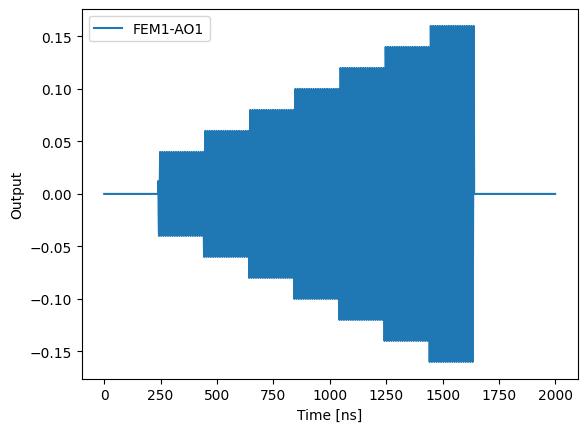

In [7]:
# get DAC and digital samples
samples = simulated_job.get_simulated_samples()

# plot all ports:
samples.con1.plot()

# get simulated results
res = simulated_job.result_handles
c = res.c.fetch_all()
print(c)  # prints a tuple of the value and timestamp

2025-11-03 15:18:14,113 - qm - INFO     - Simulating program


/Users/korrenhannes/opx_qua_course/qua-libs/venv_opx_qua_course/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1880: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


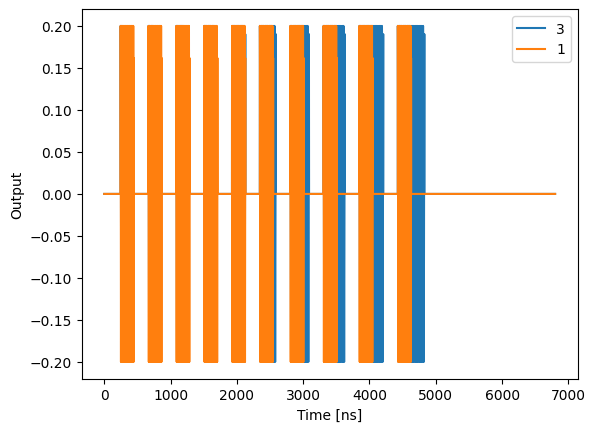

In [8]:
## Example 2:
with program() as prog2:
    d = declare(int)

    with for_(d, 10, d <= 100, d + 10):
        play("const", "qe1")
        play("const", "qe2", duration=d)
        wait(50)

# simulate program
simulated_job = qmm.simulate(
    config,
    prog2,
    SimulationConfig(
        duration=1700,  # duration of simulation in units of 4ns
    ),
)

# get DAC and digital samples
samples = simulated_job.get_simulated_samples()

# plot analog ports 1 and 3:
plt.figure()
samples.con1.plot(analog_ports={"1", "3"}, digital_ports={})


Text(0, 0.5, 'Signal [V]')

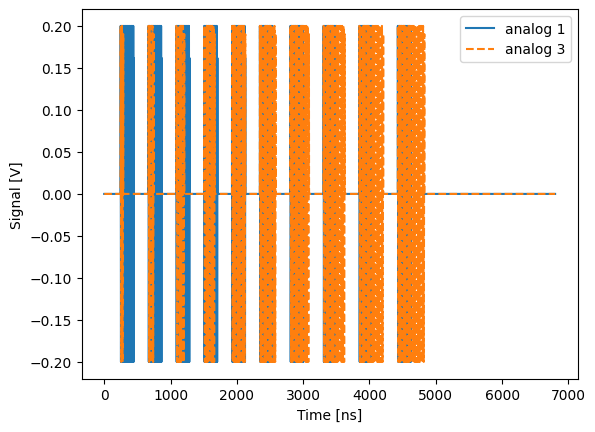

In [9]:
plt.figure()
plt.plot(samples.con1.analog["1"], "-")
plt.plot(samples.con1.analog["3"], "--")
plt.legend(("analog 1", "analog 3"))
plt.xlabel("Time [ns]")
plt.ylabel("Signal [V]")

2025-11-03 15:24:39,621 - qm - INFO     - Simulating program


/var/folders/qm/05mwj9v970vfpgxnf4rg8jr80000gn/T/ipykernel_75249/3289483955.py:18: DeprecationWarning: Saving an adc stream now requires defining it at the end of the measure command with the `adc_stream` argument, e.g. `adc_stream=adc_st`. The current syntax is deprecated and will be removed in a 1.3.
  measure("readout" * amp(a), "qe1", adc_stream, demod.full("cos", I), demod.full("sin", Q))
/Users/korrenhannes/opx_qua_course/qua-libs/venv_opx_qua_course/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1880: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


Text(0, 0.5, 'Q')

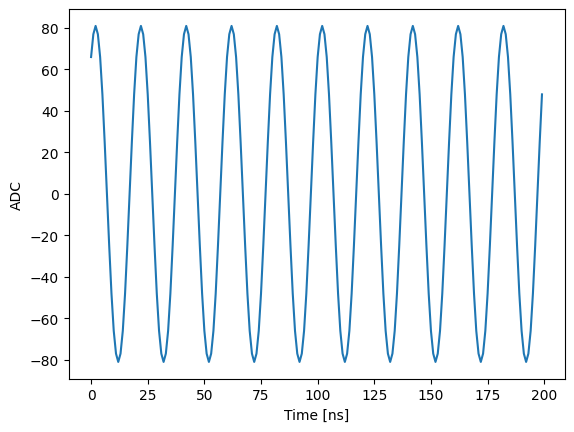

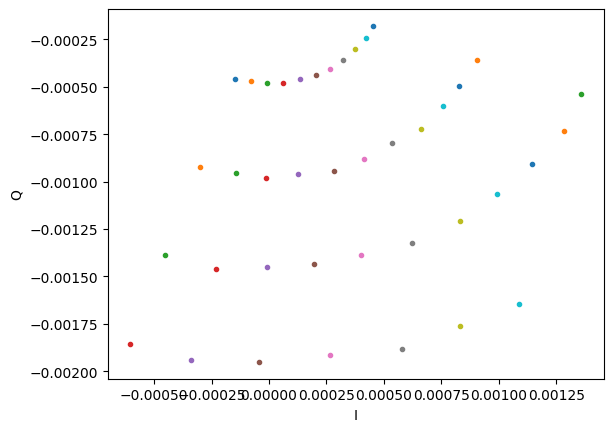

In [10]:
## Example 3 - Loopback inputs

len_a = len(np.arange(0.1, 0.45, 0.1))  # for stream processing buffer size
len_f = len(np.arange(50e6, 60e6, 1e6))  # for stream processing buffer size

with program() as prog2:
    I = declare(fixed)
    Q = declare(fixed)
    I_stream = declare_stream()
    Q_stream = declare_stream()
    adc_stream = declare_stream(adc_trace=True)
    f = declare(int)
    a = declare(fixed)

    with for_(a, 0.1, a < 0.45, a + 0.1):
        with for_(f, 50e6, f < 61e6, f + 1e6):
            update_frequency("qe1", f)
            measure("readout" * amp(a), "qe1", adc_stream, demod.full("cos", I), demod.full("sin", Q))
            save(I, I_stream)
            save(Q, Q_stream)
            wait(100)

    with stream_processing():
        I_stream.buffer(len_f).buffer(len_a).save("I")
        Q_stream.buffer(len_f).buffer(len_a).save("Q")
        adc_stream.input1().save_all("adc")
#
# simulate program
simulated_job = qmm.simulate(
    config,
    prog2,
    SimulationConfig(
        duration=40000,
        simulation_interface=LoopbackInterface([("con1", 1, "con1", 1)]),  # loopback from output 1 to input 1
    ),
)

# get results
res = simulated_job.result_handles
adc = res.get("adc").fetch_all()["value"][0]  # fetch first measurement
I = res.get("I").fetch_all()
Q = res.get("Q").fetch_all()

plt.figure()
plt.plot(adc)
plt.xlabel("Time [ns]")
plt.ylabel("ADC")

plt.figure()
plt.plot(I, Q, ".")
plt.xlabel("I")
plt.ylabel("Q")
